# Libraries import #
***
---

In [1]:
import pandas as pd     
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('bmh')
from sklearn.tree import plot_tree
import plotly.express as px


# Manipulación y tratamiento de Datos
import numpy as np
import pandas as pd
# Visualización de datos
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Modelación Arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

# Métrica de Evaluación
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

# No presentar advertencias
import warnings
warnings.filterwarnings("ignore")
from DateTime import DateTime



# Extract the Dataset | Only working with "XOM" Exxon Mobil #
***
---

In [3]:
df= pd.read_csv("/Users/me/Desktop/ML_ExxonMobile_Forecast/src/data/oil and gas stock prices.csv")
df = df.loc[df.Symbol=="XOM"]
df.head()
df.index = pd.to_datetime(df.Date)
df = df[["Close"]].copy()
df.rename(columns={"Close":"Value"},inplace=True)
df.head()

,Value
Date,
2000-01-03,39.16
2000-01-04,38.41
2000-01-05,40.50
2000-01-06,42.59
2000-01-07,42.47


# Setting the Frequency to Daily #
- In this way we can use the Datetimeindex functions

In [4]:
freq = pd.infer_freq(df.index)
df.index.freq = freq
ts_resampled =df.asfreq('D')
print(ts_resampled)

             Value
Date              
2000-01-03   39.16
2000-01-04   38.41
2000-01-05   40.50
2000-01-06   42.59
2000-01-07   42.47
...            ...
2022-06-06   98.84
2022-06-07  103.37
2022-06-08  104.59
2022-06-09  102.33
2022-06-10  100.46

[8195 rows x 1 columns]


# Verification #


In [5]:
freq = pd.infer_freq(ts_resampled.index)

print(freq)

D


# Filling the NAN values #

In [6]:
df = ts_resampled.fillna(method='ffill')


# Feature engineering for data exploration #

In [7]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['weekofyear'] = df.index.isocalendar().week
    df['year'] = df.index.year
    return df

df = create_features(df)


### Box plots ###
- With the box plots we can see the median, the outliers and the quartiles

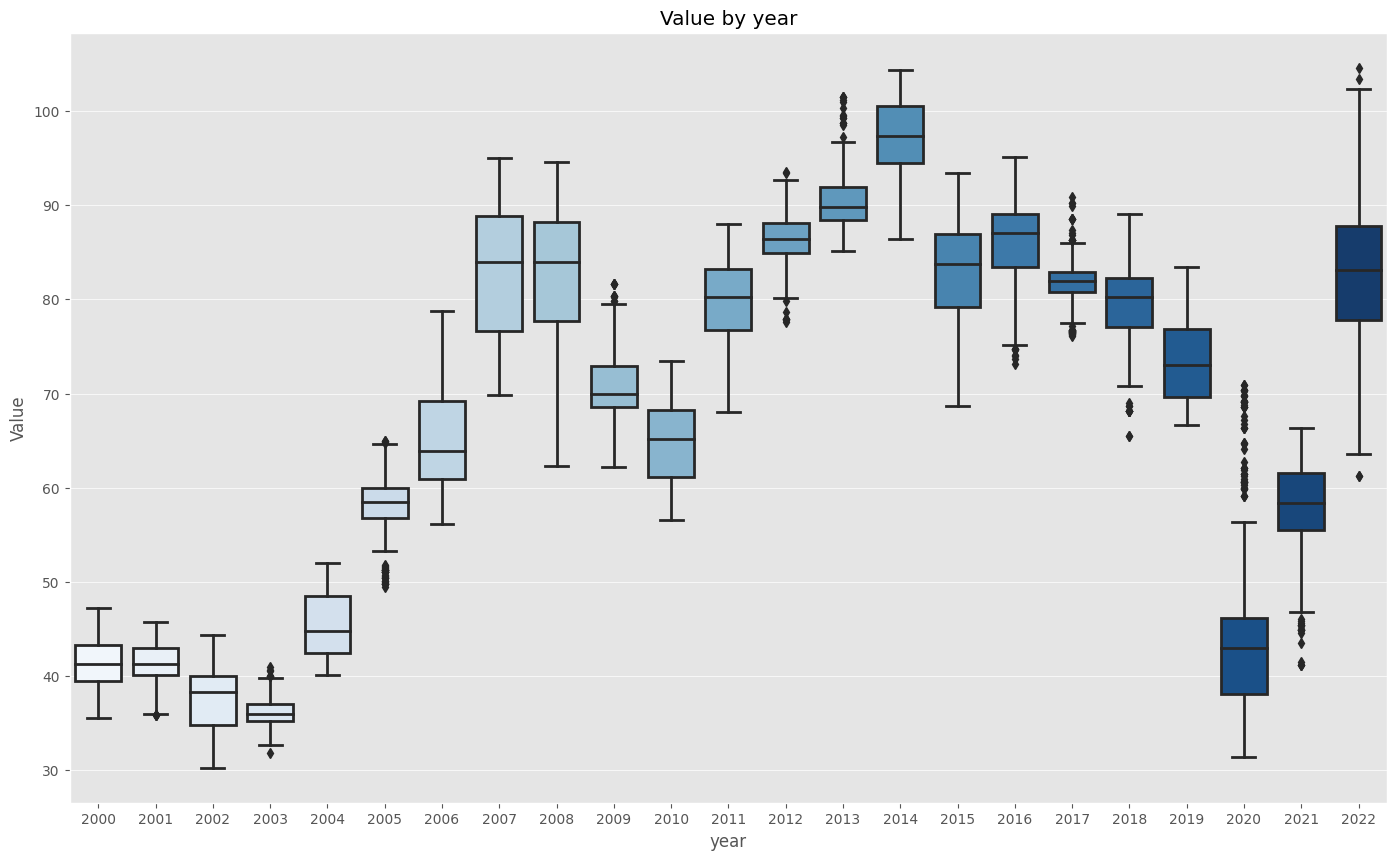

In [8]:
fig, ax = plt.subplots(figsize=(17, 10))
sns.boxplot(data=df, x="year", y='Value', palette='Blues')
ax.set_title('Value by year')
plt.show()

# "Reshaping" the dataframe #

In [9]:
df= df[["Value"]].copy()

In [10]:
fig= px.line(df, x=df.index, y="Value", title="Exxon Mobile")
fig.show()

# Outliers detection #
- We have Several outliers from 2000-2005 and 2021 
- The first round are far from the "Regular price" but at the same time we had a downfall due COVID-19 
- We kept the outliers, we are going to remove a big load of observations so the cleaning is not necessary



<Axes: ylabel='Frequency'>

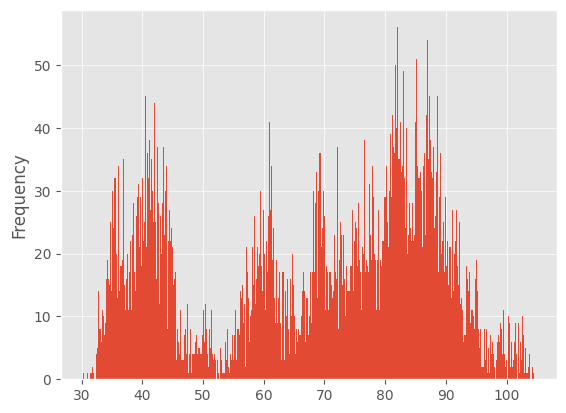

In [11]:
df["Value"].plot(kind='hist', bins=500)


### The identification of "Outliers" were prices in the Close of the day from 2000 to 20022 ###
- The outliers were the closing values under 40 USD 


<Axes: title={'center': 'Outliers'}, xlabel='Date'>

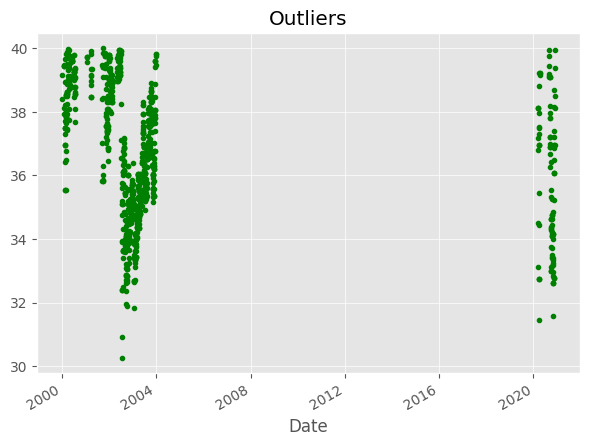

In [12]:
df.query("Value < 40")["Value"] \
    .plot(style='.',
          figsize=(7, 5),
          color="green",
          title='Outliers')

count    8195.000000
mean       67.955834
std        19.417915
min        30.270000
25%        48.260000
50%        72.130000
75%        84.025000
max       104.590000
Name: Value, dtype: float64

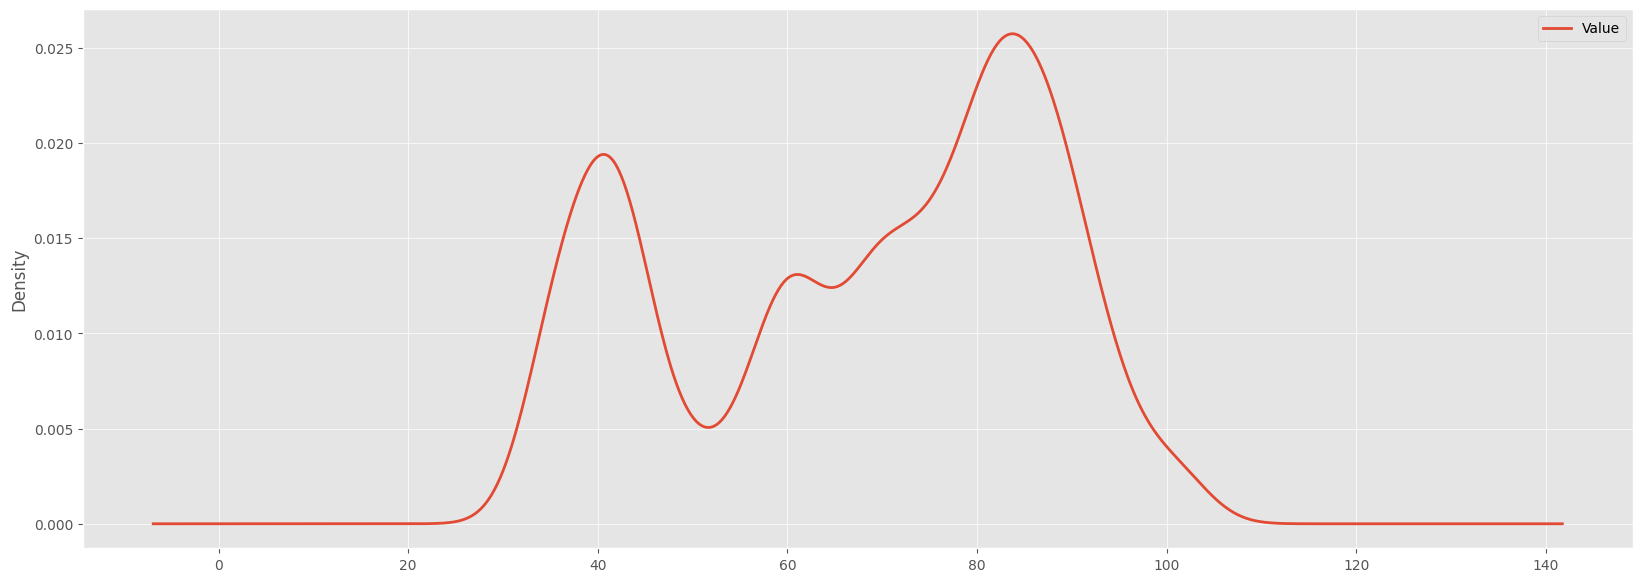

In [13]:
df.plot(kind="kde",figsize=(20,7))
df["Value"].describe()

In [14]:
def Prueba_Dickey_Fuller(series):
    
    print (f"Resultados de la prueba de Dickey-Fuller")
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        StopIteration

In [15]:
Prueba_Dickey_Fuller(df)

Resultados de la prueba de Dickey-Fuller
Test Statistic                          -1.575803
p-value                                  0.495736
No Lags Used                             9.000000
Número de observaciones utilizadas    8185.000000
Critical Value (1%)                     -3.431149
Critical Value (5%)                     -2.861893
Critical Value (10%)                    -2.566958
dtype: float64


# Reshaping information #
- In the Seasonal-Arima we saw a big difference in the AIC value when we reduced the amount of observations, let´s keep it that way

In [21]:
start_date = pd.to_datetime('2018-01-01')  # Specify the start date of the 4-year period

df = df.loc[df.index >= start_date]

## Creation of lags ##
- Creation of Lags for the implementation of different algorithms such XGboost and Random Forest

In [43]:
for i in range(12,0,-1):
    df["t-"+str(i)] = df["Value"].shift(i)

In [44]:
df.dropna(inplace=True)
df.head(15)

,Value,t-4,t-3,t-2,t-1,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5
Date,,,,,,,,,,,,,
2018-01-21,87.15,88.00,87.43,87.15,87.15,86.77,86.08,86.93,87.52,87.52,87.52,87.52,86.97
2018-01-22,88.25,87.43,87.15,87.15,87.15,86.08,86.93,87.52,87.52,87.52,87.52,86.97,88.00
2018-01-23,88.30,87.15,87.15,87.15,88.25,86.93,87.52,87.52,87.52,87.52,86.97,88.00,87.43
2018-01-24,88.53,87.15,87.15,88.25,88.30,87.52,87.52,87.52,87.52,86.97,88.00,87.43,87.15
2018-01-25,88.37,87.15,88.25,88.30,88.53,87.52,87.52,87.52,86.97,88.00,87.43,87.15,87.15
2018-01-26,89.00,88.25,88.30,88.53,88.37,87.52,87.52,86.97,88.00,87.43,87.15,87.15,87.15
2018-01-27,89.00,88.30,88.53,88.37,89.00,87.52,86.97,88.00,87.43,87.15,87.15,87.15,88.25
2018-01-28,89.00,88.53,88.37,89.00,89.00,86.97,88.00,87.43,87.15,87.15,87.15,88.25,88.30
2018-01-29,88.01,88.37,89.00,89.00,89.00,88.00,87.43,87.15,87.15,87.15,88.25,88.30,88.53


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1602 entries, 2018-01-21 to 2022-06-10
Freq: D
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   1602 non-null   float64
 1   t-4     1602 non-null   float64
 2   t-3     1602 non-null   float64
 3   t-2     1602 non-null   float64
 4   t-1     1602 non-null   float64
 5   t-12    1602 non-null   float64
 6   t-11    1602 non-null   float64
 7   t-10    1602 non-null   float64
 8   t-9     1602 non-null   float64
 9   t-8     1602 non-null   float64
 10  t-7     1602 non-null   float64
 11  t-6     1602 non-null   float64
 12  t-5     1602 non-null   float64
dtypes: float64(13)
memory usage: 175.2 KB


In [46]:
train_data =df[:len(df)-324]
test_data =df[len(df)-324:]

In [47]:
train_data.tail()

,Value,t-4,t-3,t-2,t-1,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5
Date,,,,,,,,,,,,,
2021-07-17,57.32,60.88,59.53,58.95,57.32,63.17,61.37,60.41,60.14,61.23,61.23,61.23,61.17
2021-07-18,57.32,59.53,58.95,57.32,57.32,61.37,60.41,60.14,61.23,61.23,61.23,61.17,60.88
2021-07-19,55.35,58.95,57.32,57.32,57.32,60.41,60.14,61.23,61.23,61.23,61.17,60.88,59.53
2021-07-20,55.96,57.32,57.32,57.32,55.35,60.14,61.23,61.23,61.23,61.17,60.88,59.53,58.95
2021-07-21,57.76,57.32,57.32,55.35,55.96,61.23,61.23,61.23,61.17,60.88,59.53,58.95,57.32


## Train & Test ##


In [48]:

X_train = train_data.iloc[:, 1:].values
X_test = test_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
y_test = test_data.iloc[:, 0].values

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)



Shape X_train: (1278, 12)
Shape X_test: (324, 12)
Shape y_train: (1278,)
Shape y_test: (324,)


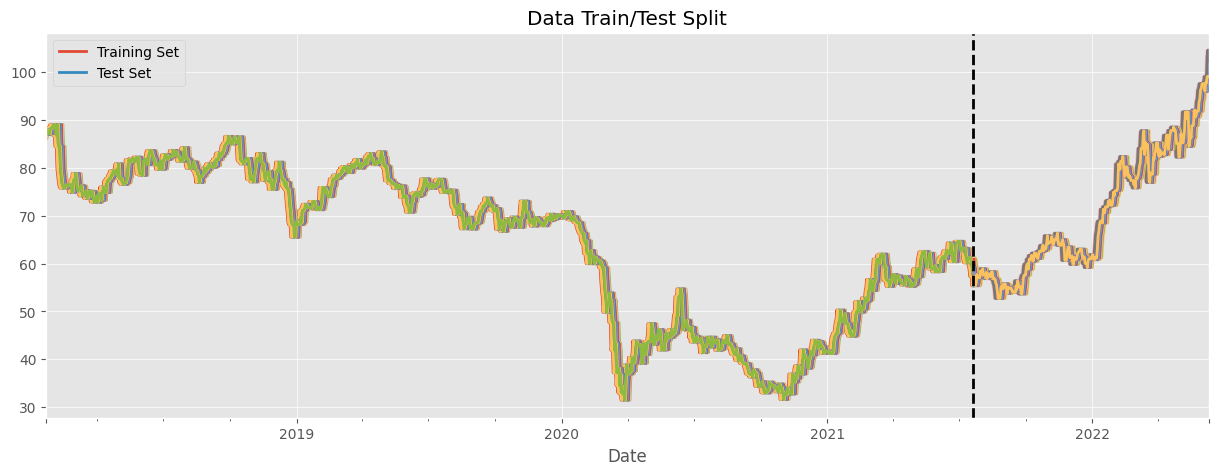

In [49]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_data.plot(ax=ax, label='Test Set')
ax.axvline('2021-07-21', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Implementation of a Decission Tree Regressor ###


In [50]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()

tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [51]:
def prediction(model, x_test):
    preds = x_test[0]
    preds_out = []
    
    for i in range(len(X_test)):
        pred = model.predict([preds])[0]
        preds_out.append(pred)
        
        preds2 = np.array([preds[1:]]) 
        
        preds = np.c_[preds2, np.array([pred])][0]
        
    return preds_out

In [52]:
preds = prediction(tree, X_test)


### Visualization of the prediction ###
y_test values were in the downfall of the prices of 2021 due the COVID-19
Stock prices are volatily and subjected to several factors like OPEC regulations and social impact 
***
---

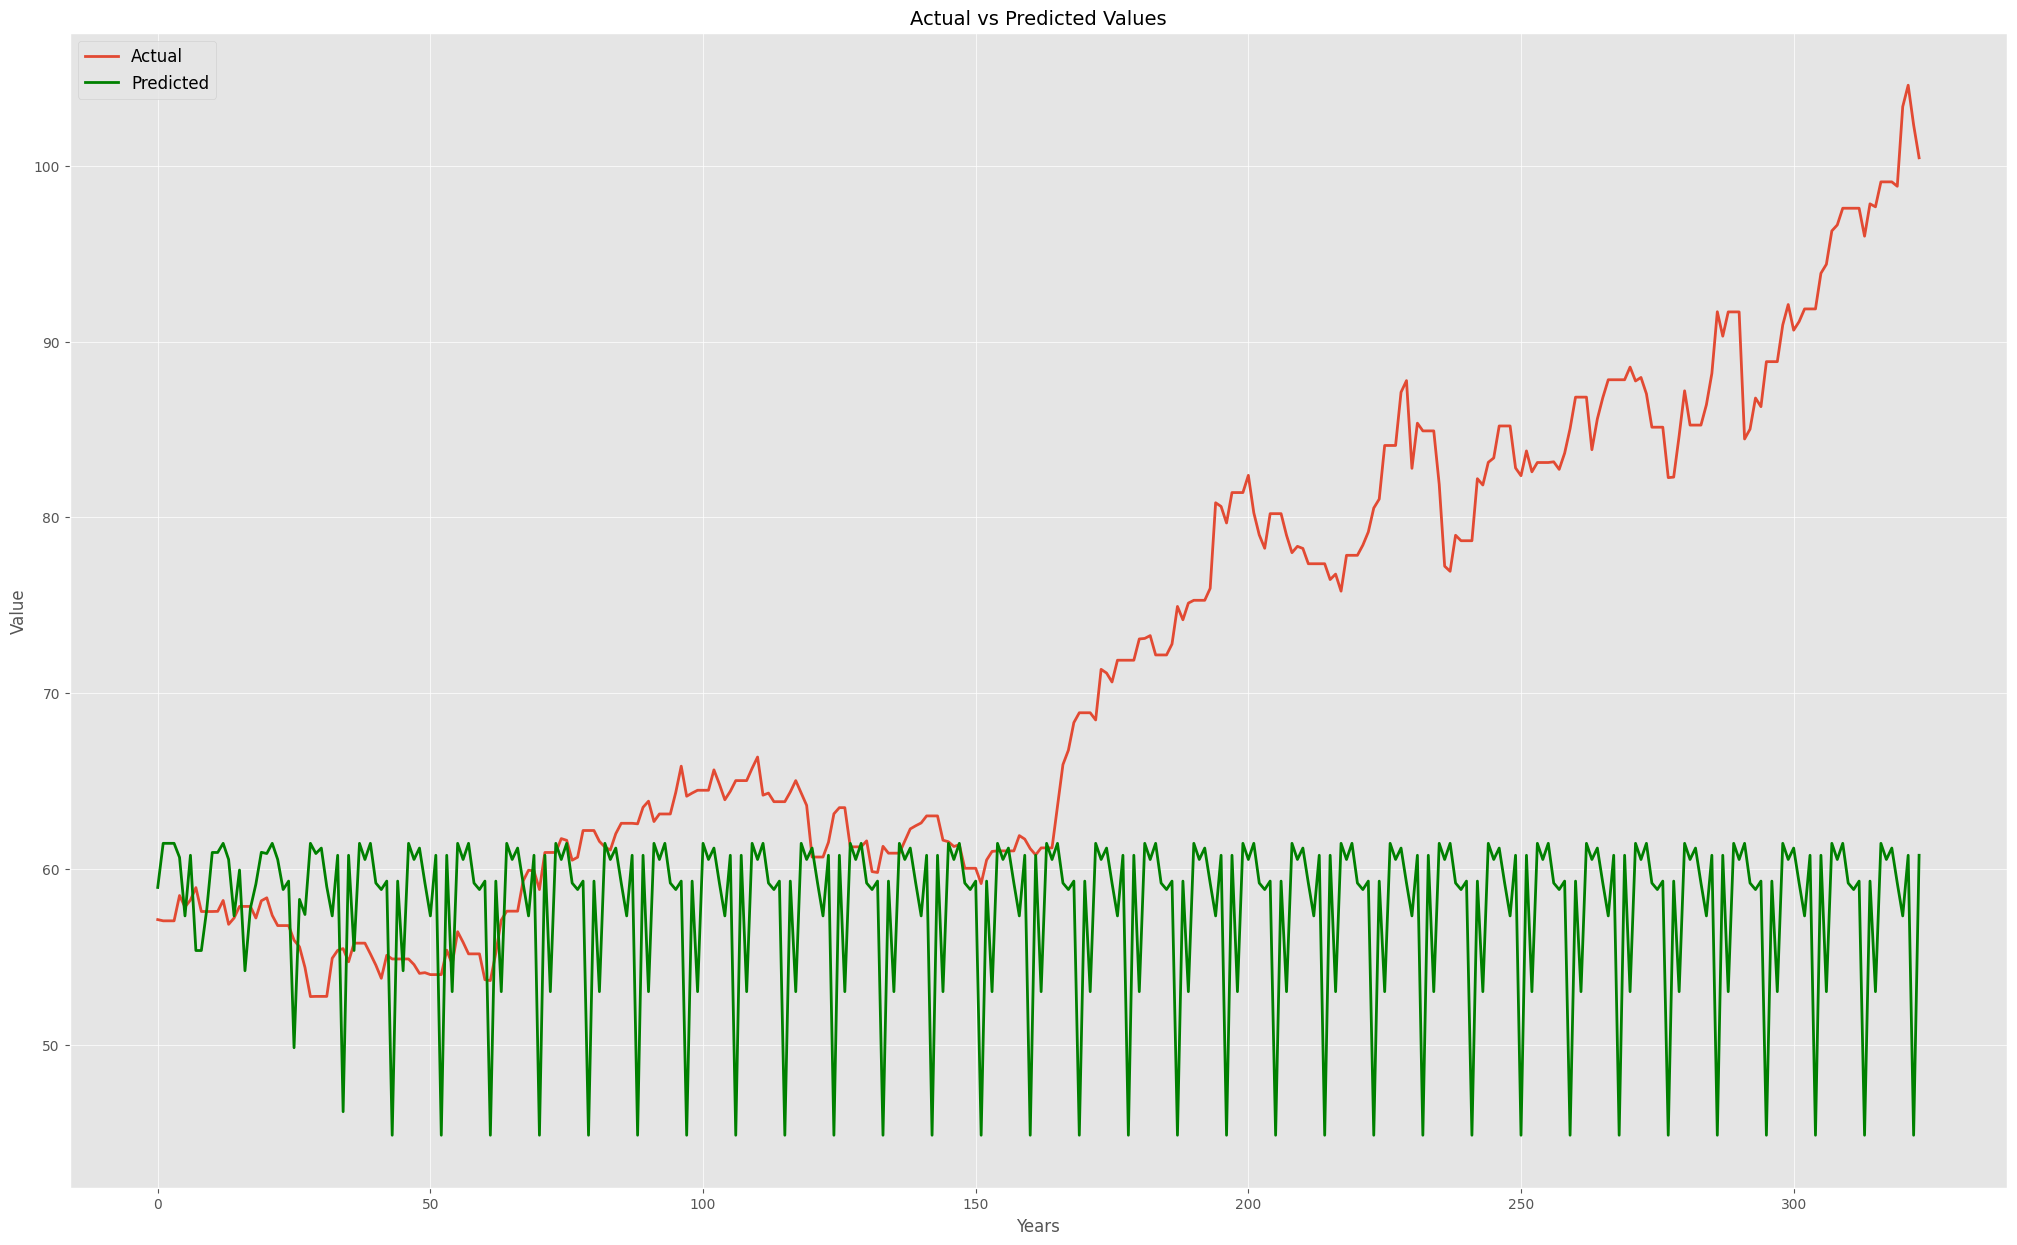

In [53]:
plt.figure(figsize=(25, 15))
plt.plot(y_test, '-', label='Actual')
plt.plot(preds, '-', color='green', label='Predicted')
plt.xlabel('Years', fontsize=12)
plt.ylabel('Value', fontsize=12)

plt.title('Actual vs Predicted Values', fontsize=14)
plt.legend(fontsize=12)
plt.show()

### Mean squared error ###
***
---

In [34]:
print("MSE:", mean_squared_error(preds, y_test))



MSE: 328.6658037037037


In [35]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.5],
}

# Create an instance of the XGBRegressor model
xgb = XGBRegressor(random_state=42)

# Create a GridSearchCV object and fit it to the data
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)


Best parameters:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
Best score:  2.2449327288484797


In [36]:
model = XGBRegressor(n_estimators=200, max_depth=2, learning_rate=0.01)


In [37]:
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [38]:
predictions = model.predict(X_test)


In [39]:
mse = mean_squared_error(y_test, predictions)
print('MSE:', mse)

MSE: 149.51666666289117


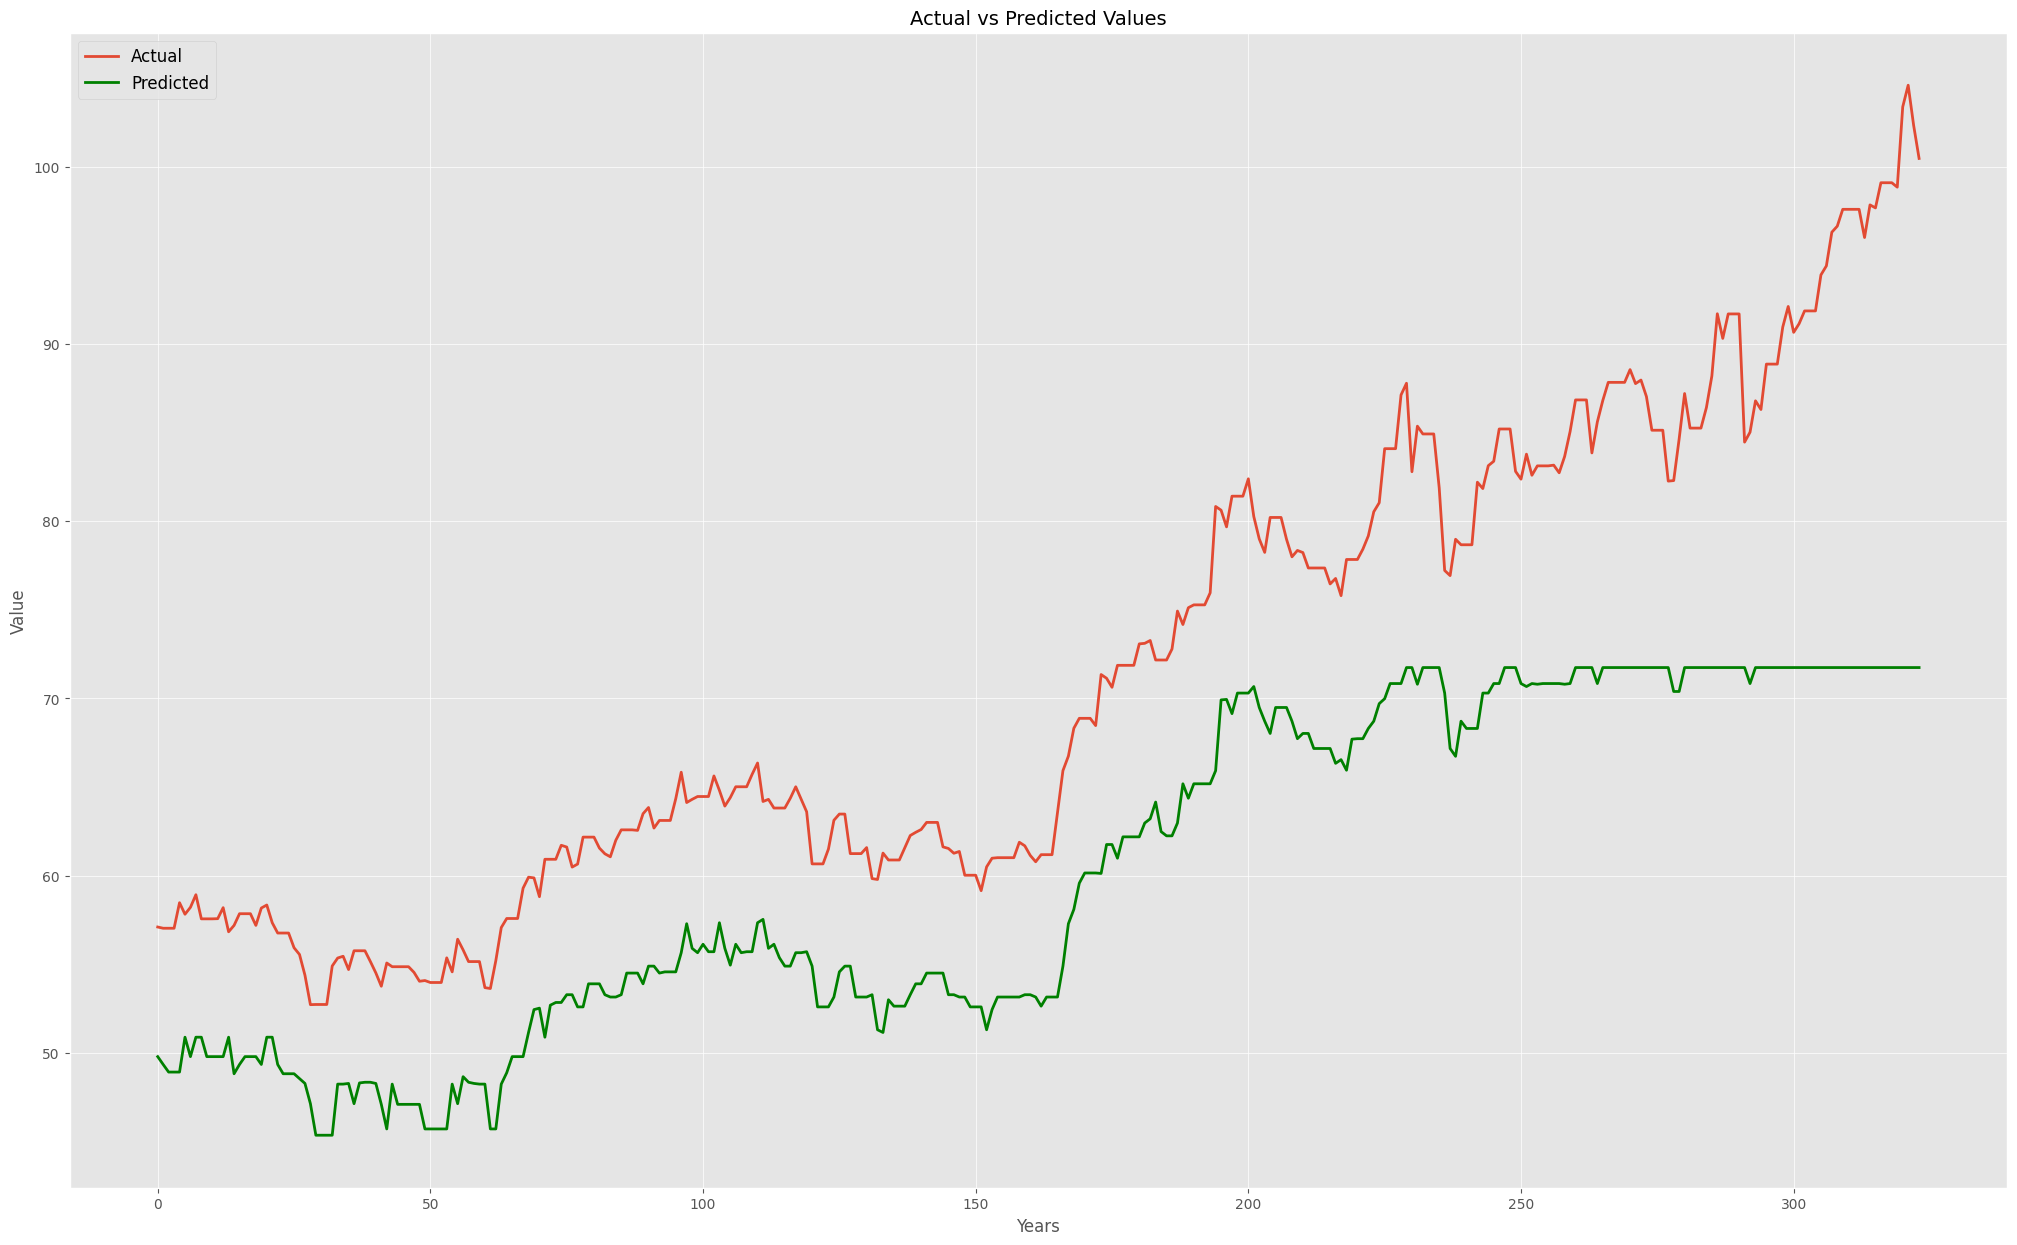

In [40]:
plt.figure(figsize=(25, 15))
plt.plot(y_test, '-', label='Actual')
plt.plot(predictions, '-', color='green', label='Predicted')
plt.xlabel('Years', fontsize=12)
plt.ylabel('Value', fontsize=12)

plt.title('Actual vs Predicted Values', fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [41]:
def evaluacion_metrica(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [42]:
evaluacion_metrica(y_test, predictions)


Evaluation metric results:-
MSE is : 149.51666666289117
MAE is : 11.153437019159766
RMSE is : 12.227700792172303
MAPE is : 15.144134832196066
R2 is : 0.16595106398301285



In [38]:
from prophet import Prophet


In [39]:
mf= pd.read_csv("/Users/me/Desktop/ML_clon/src/data/oil and gas stock prices.csv")
mf = mf.loc[mf.Symbol=="XOM"]
mf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5647 entries, 0 to 5646
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      5647 non-null   object 
 1   Symbol    5647 non-null   object 
 2   Open      5647 non-null   float64
 3   High      5647 non-null   float64
 4   Low       5647 non-null   float64
 5   Close     5647 non-null   float64
 6   Volume    5647 non-null   int64  
 7   Currency  5647 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 397.1+ KB


In [40]:
mf.Date = pd.to_datetime(mf.Date)
mf = mf[["Date","Close"]].copy()
mf.rename(columns={"Date":"ds","Close":"y"},inplace=True)
mf.head()

,ds,y
0,2000-01-03,39.16
1,2000-01-04,38.41
2,2000-01-05,40.50
3,2000-01-06,42.59
4,2000-01-07,42.47


In [41]:
train_data_pr = mf.iloc[:4500]
test_data_pr = mf.iloc[4500:]

In [42]:
test_data_pr.shape

(1147, 2)

In [43]:
train_data_pr.shape

(4500, 2)

In [44]:
mf.shape

(5647, 2)

In [45]:
m = Prophet()
m.fit(train_data_pr)

00:23:01 - cmdstanpy - INFO - Chain [1] start processing
00:23:04 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
future = m.make_future_dataframe(periods=12,freq='D')
prophet_pred = m.predict(future)

In [47]:
prophet_pred


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-03,39.777548,35.841637,45.862675,39.777548,39.777548,0.923521,0.923521,0.923521,0.140068,0.140068,0.140068,0.783452,0.783452,0.783452,0.0,0.0,0.0,40.701069
1,2000-01-04,39.784321,35.790129,45.620990,39.784321,39.784321,1.006593,1.006593,1.006593,0.236365,0.236365,0.236365,0.770228,0.770228,0.770228,0.0,0.0,0.0,40.790914
2,2000-01-05,39.791094,35.607053,45.709710,39.791094,39.791094,0.961731,0.961731,0.961731,0.209355,0.209355,0.209355,0.752376,0.752376,0.752376,0.0,0.0,0.0,40.752825
3,2000-01-06,39.797867,35.683646,45.870463,39.797867,39.797867,0.904746,0.904746,0.904746,0.174909,0.174909,0.174909,0.729837,0.729837,0.729837,0.0,0.0,0.0,40.702613
4,2000-01-07,39.804640,35.739803,45.705008,39.804640,39.804640,0.882202,0.882202,0.882202,0.179590,0.179590,0.179590,0.702612,0.702612,0.702612,0.0,0.0,0.0,40.686842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4507,2017-11-25,78.581866,73.132931,82.919517,78.581866,78.581866,-0.585310,-0.585310,-0.585310,-0.470144,-0.470144,-0.470144,-0.115167,-0.115167,-0.115167,0.0,0.0,0.0,77.996556
4508,2017-11-26,78.569972,73.067349,83.035993,78.569972,78.569972,-0.567905,-0.567905,-0.567905,-0.470143,-0.470143,-0.470143,-0.097761,-0.097761,-0.097761,0.0,0.0,0.0,78.002067
4509,2017-11-27,78.558078,73.957249,83.761566,78.558078,78.558078,0.061586,0.061586,0.061586,0.140068,0.140068,0.140068,-0.078483,-0.078483,-0.078483,0.0,0.0,0.0,78.619663
4510,2017-11-28,78.546183,73.501969,83.439698,78.546183,78.546183,0.178952,0.178952,0.178952,0.236365,0.236365,0.236365,-0.057412,-0.057412,-0.057412,0.0,0.0,0.0,78.725136


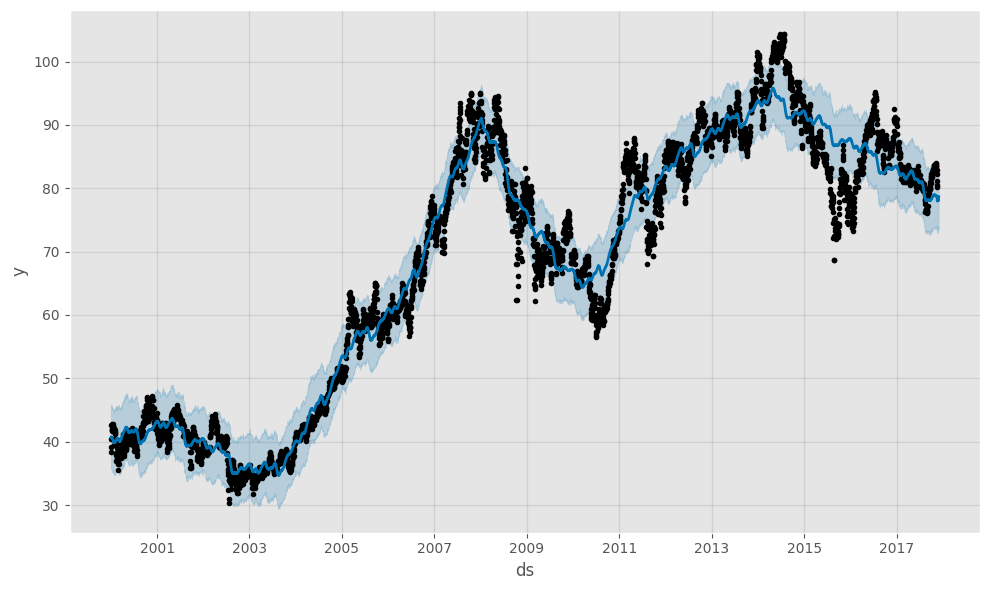

In [48]:
fig1 = m.plot(prophet_pred)


In [60]:
evaluacion_metrica(test_data_pr["y"], prophet_pred['Pred'])


Evaluation metric results:-
MSE is : 681.8545170600476
MAE is : 22.47922755471903
RMSE is : 26.112344150995856
MAPE is : 42.46720539670677
R2 is : -1.7469284515319505



In [40]:
from sklearn.metrics import mean_squared_error, r2_score


y_pred = tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean squared error: {mse}")
print(f"R-squared: {r2}")



from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(tree, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")


Mean squared error: 2.085539333234773
R-squared: 0.9915800087669296
Cross-validation scores: [0.93347108 0.97861048 0.97082513 0.97307426 0.96240774]


In [41]:
df.iloc[5000,:]

Value    88.40
t-4      88.84
t-3      87.98
t-2      88.40
t-1      88.40
Name: 2013-09-15 00:00:00, dtype: float64

In [42]:
new_data = df.iloc[5000,1:].values.reshape(1, -1)
new_pred = tree.predict(new_data)
print(f"New prediction: {new_pred}")

New prediction: [88.4]


In [43]:
import joblib
joblib.dump(tree, 'decision_tree_model.joblib')


['decision_tree_model.joblib']

In [44]:
X_test

array([[ 83.11,  83.11,  83.11,  83.24],
       [ 83.11,  83.11,  83.24,  83.47],
       [ 83.11,  83.24,  83.47,  83.17],
       ...,
       [ 99.09,  99.09,  98.84, 103.37],
       [ 99.09,  98.84, 103.37, 104.59],
       [ 98.84, 103.37, 104.59, 102.33]])

In [38]:
import joblib

model = joblib.load("decision_tree_model.joblib")

predictions = model.predict(X_test)
pr = pd.DataFrame(predictions)
print(pr)

           0
0      82.77
1      83.35
2      83.98
3      83.47
4      82.77
...      ...
1678   98.51
1679   99.26
1680  102.59
1681  102.73
1682  102.01

[1683 rows x 1 columns]


In [54]:
%pip install tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.1/230.1 MB 8.3 MB/s eta 0:00:0000:0100:01
  Using cached grpcio-1.54.0.tar.gz (23.5 MB)
  Preparing metadata (setup.py) ... done
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.12.2-py3-none-any.whl (5.6 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached libclang-16.0.0-py2.py3-none-macosx_10_9_x86_64.whl (26.7 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached protobuf-4.22.3-cp37-abi3-macosx_10_9_universal2.whl (397 kB)
  Using cached flatbuffers-23.3.3-py2.py3-none-any.whl (26 kB)
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl (440 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.5 MB/s eta 0:00:00a 0:00:01
  Using cached jax-0.4.8.tar.gz (1.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached astunparse-1.6.3-py2.